In [16]:
import torch
import hamiltorch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
class Net(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x#torch.softmax(x)
#         return F.log_softmax(x, dim=1)
net = Net()

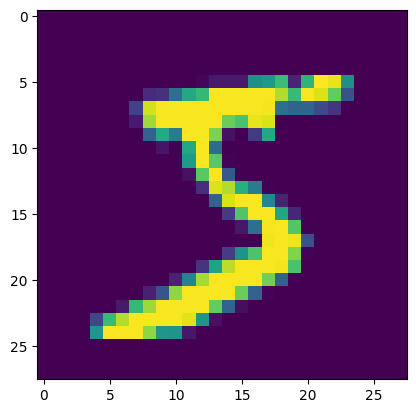

In [18]:
import torchvision
import torchvision.datasets as datasets
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='../../data', train=False, download=True, transform=None)
plt.imshow(mnist_trainset.train_data[0].reshape((28,28)))
plt.show()
D = 784
N_tr = 100
N_val = 1000


x_train = mnist_trainset.train_data[:N_tr].float()/255.
x_train = x_train[:,None]
y_train = mnist_trainset.train_labels[:N_tr].reshape((-1,1)).float()
x_val = mnist_trainset.train_data[N_tr:N_tr+N_val].float()/255.
x_val = x_val[:,None]
y_val = mnist_trainset.train_labels[N_tr:N_tr+N_val].reshape((-1,1)).float()

x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

Files already downloaded and verified
Files already downloaded and verified


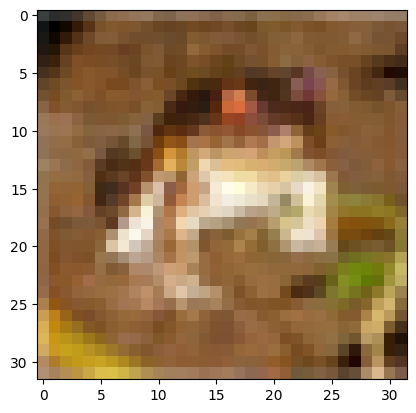

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modification du réseau pour CIFAR-10
class Net(nn.Module):
    """Un ConvNet un peu plus sophistiqué pour CIFAR-10"""
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.fc1 = nn.Linear(4*4*256, 512)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 4*4*256)
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = self.fc2(x)
        return x


net = Net().to(device)

# Chargement de CIFAR-10 avec transformation (normalisation et conversion en tensor)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisation
])

cifar_trainset = torchvision.datasets.CIFAR10(root='../../data', train=True, download=True, transform=transform)
cifar_testset = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transform)

# Sélection d'un sous-ensemble des données
N_tr = 100  # Taille réduite du dataset d'entraînement
N_val = 1000  # Taille réduite du dataset de validation

x_train = torch.stack([cifar_trainset[i][0] for i in range(N_tr)]).to(device)
y_train = torch.tensor([cifar_trainset[i][1] for i in range(N_tr)], dtype=torch.float32).reshape((-1, 1)).to(device)

x_val = torch.stack([cifar_trainset[i][0] for i in range(N_tr, N_tr + N_val)]).to(device)
y_val = torch.tensor([cifar_trainset[i][1] for i in range(N_tr, N_tr + N_val)], dtype=torch.float32).reshape((-1, 1)).to(device)

# Affichage d'une image pour vérification
plt.imshow(cifar_trainset.data[0])
plt.show()


In [35]:
tau_list = []
var = 1
tau = 1/var #10.#./100. # 1/50 var = 1/tau
for w in net.parameters():
#     print(w.nelement())
#     tau_list.append(tau/w.nelement())
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

hamiltorch.set_random_seed(123)
net = Net().to(device)
params_init = hamiltorch.util.flatten(net).to(device).clone()
print(params_init.shape)

step_size = 0.0001 #1#0.01# 0.003#0.002
num_samples = 200 #2000 # 3000
L = 200 #3 # num steps per samples (leapfrog)
tau_out = 1.
normalizing_const = 1.
burn =40 #GPU: 3000

params_hmc = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, model_loss='multi_class_linear_output', num_samples=num_samples, burn = burn,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const)

torch.Size([431080])
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:03:44 | 0d:00:00:00 | #################### | 200/200 | 0.90       
Acceptance Rate 0.98


In [50]:
# Explicit

hamiltorch.set_random_seed(123)
net = Net().to(device)
params_init = hamiltorch.util.flatten(net).to(device).clone()
print(params_init.shape)

step_size = 0.0001 #1#0.01# 0.003#0.002
num_steps_per_sample = 3000
num_samples = 10 #2000 # 3000
L = 30 #3
tau_out = 1.
normalizing_const = 1.
burn =0 #GPU: 3000

params_hmc = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, model_loss='multi_class_linear_output', num_samples=num_samples, burn = burn, 
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const, integrator=hamiltorch.Integrator.EXPLICIT)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 37.12 MiB is free. Process 2611 has 15.85 GiB memory in use. Of the allocated memory 14.65 GiB is allocated by PyTorch, and 916.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [36]:
%time pred_list, log_prob_list = hamiltorch.predict_model(net, x = x_val, y = y_val, samples=params_hmc, model_loss='multi_class_log_softmax_output', tau_out=1., tau_list=tau_list)
_, pred = torch.max(pred_list, 2)
acc = []
acc = torch.zeros( int(len(params_hmc))-1)
nll = torch.zeros( int(len(params_hmc))-1)
ensemble_proba = F.softmax(pred_list[0], dim=-1)
for s in range(1,len(params_hmc)):
    _, pred = torch.max(pred_list[:s].mean(0), -1)
    acc[s-1] = (pred.float() == y_val.flatten()).sum().float()/y_val.shape[0]
    ensemble_proba += F.softmax(pred_list[s], dim=-1)
    nll[s-1] = F.nll_loss(torch.log(ensemble_proba.cpu()/(s+1)), y_val[:].long().cpu().flatten(), reduction='mean')

CPU times: user 694 ms, sys: 421 ms, total: 1.12 s
Wall time: 1.12 s


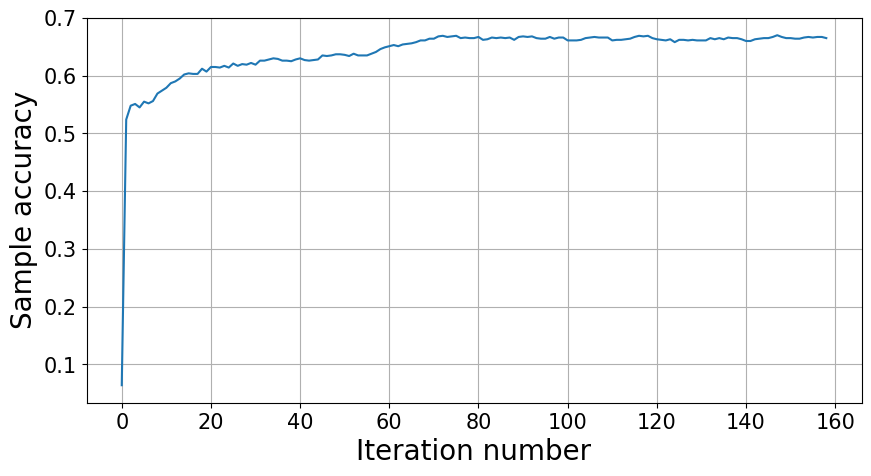

In [33]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(acc)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Sample accuracy',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

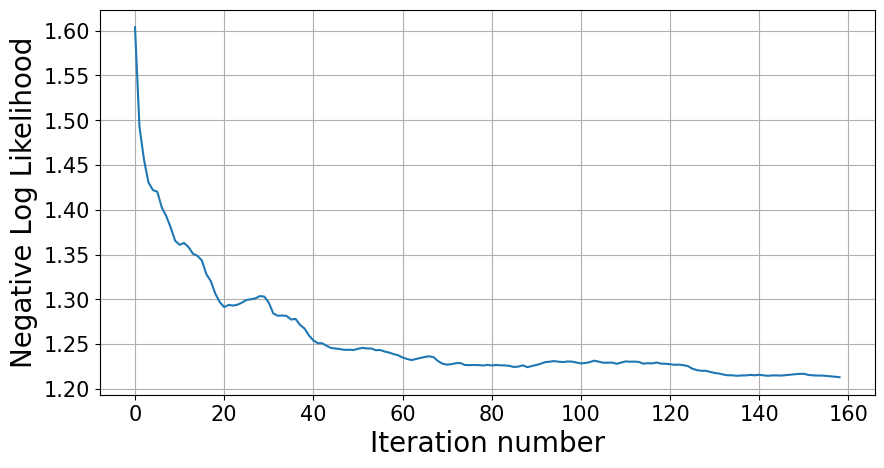

In [34]:
fs = 20
plt.figure(figsize=(10,5))
plt.plot(nll)
plt.grid()
# plt.xlim(0,3000)
plt.xlabel('Iteration number',fontsize=fs)
plt.ylabel('Negative Log Likelihood',fontsize=fs)
plt.tick_params(labelsize=15)
# plt.savefig('mnist_acc_100_training.png')
plt.show()

In [8]:
step_size = 0.0001 #1#0.01# 0.003#0.002
num_samples = 180 #2000 # 3000
L = 200 #3 # num steps per samples (leapfrog)
tau_out = 1.
normalizing_const = 1.
burn =40 #GPU: 3000

hamiltorch.set_random_seed(123)
net = Net().to(device)
params_init = hamiltorch.util.flatten(net).to(device).clone()
params_hmc_1 = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, model_loss='multi_class_linear_output', num_samples=num_samples, burn = burn,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const)


hamiltorch.set_random_seed(231)
net = Net()
params_init = hamiltorch.util.flatten(net).to(device).clone()
params_hmc_2 = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, model_loss='multi_class_linear_output', num_samples=num_samples, burn = burn,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const)



hamiltorch.set_random_seed(321)
net = Net()
params_init = hamiltorch.util.flatten(net).to(device).clone()
params_hmc_3 = hamiltorch.sample_model(net, x_train, y_train, params_init=params_init, model_loss='multi_class_linear_output', num_samples=num_samples, burn = burn,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out, tau_list=tau_list, normalizing_const=normalizing_const)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:03:38 | 0d:00:00:00 | #################### | 180/180 | 0.83       
Acceptance Rate 1.00
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:03:23 | 0d:00:00:00 | #################### | 180/180 | 0.89       
Acceptance Rate 0.99
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
0d:00:03:25 | 0d:00:00:00 | #################### | 180/180 | 0.88       
Acceptance Rate 0.99


### 3 chaînes différentes

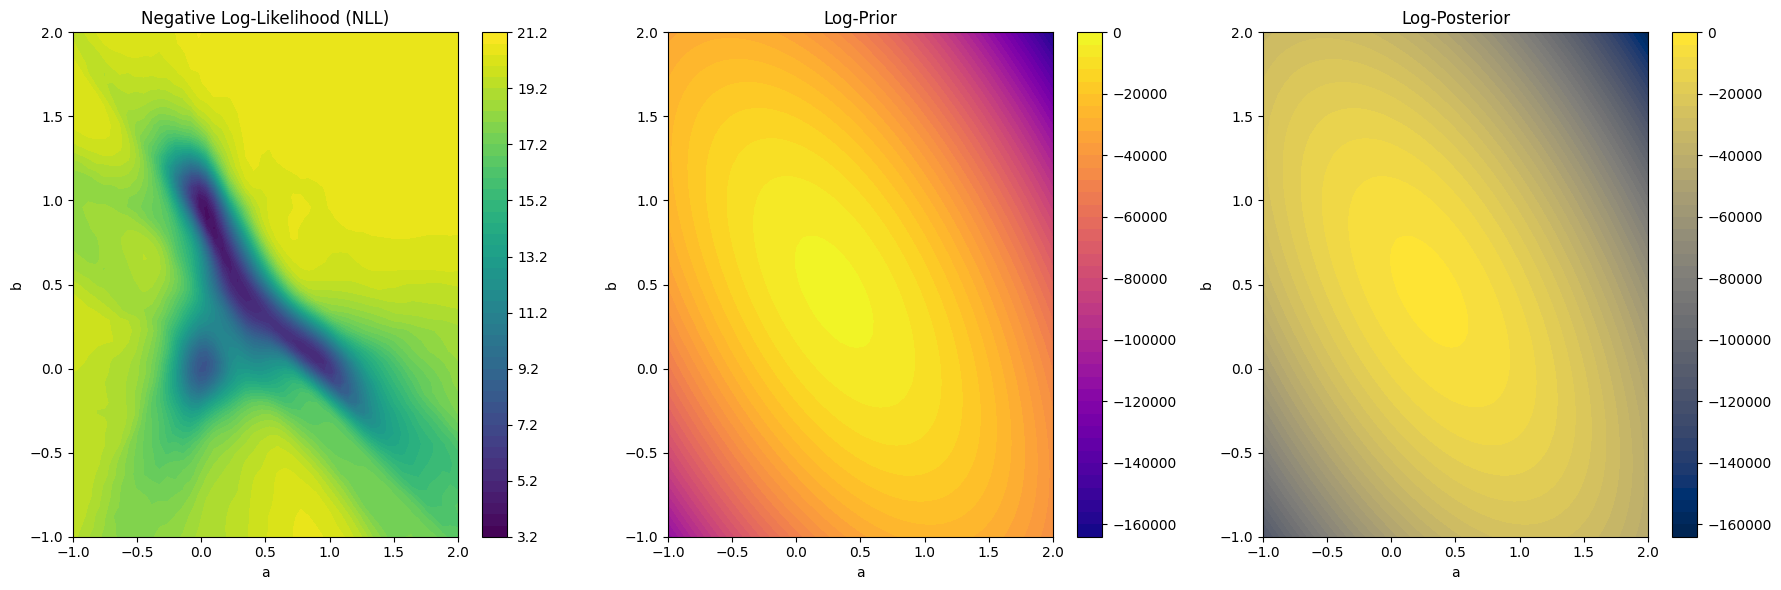

In [23]:
import torch
import hamiltorch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## DIFFERENTES CHAINES
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sélectionner 3 échantillons (1er, 50e, 100e)
w1 = params_hmc_1[40].clone()
w2 = params_hmc_2[100].clone()
w3 = params_hmc_3[139].clone()

# Définir les coefficients a et b
grid_size = 50
a_range = torch.linspace(-1, 2, grid_size)
b_range = torch.linspace(-1, 2, grid_size)

# Construire la grille de paramètres
theta_grid = torch.zeros(grid_size, grid_size, w1.shape[0], device=device)

for i, a in enumerate(a_range):
    for j, b in enumerate(b_range):
        theta_grid[i, j] = a * w1 + b * w2 + (1 - a - b) * w3

# Aplatir la grille pour utiliser predict_model
theta_grid_flat = theta_grid.view(-1, w1.shape[0])

# Prédictions avec hamiltorch
pred_list, _ = hamiltorch.predict_model(
    net, x=x_val, y=y_val, samples=theta_grid_flat, 
    model_loss='multi_class_log_softmax_output', tau_out=1., tau_list=tau_list
)

# Initialisation des grilles
nll_grid = torch.zeros(grid_size, grid_size, device=device)
log_prior_grid = torch.zeros(grid_size, grid_size, device=device)
log_posterior_grid = torch.zeros(grid_size, grid_size, device=device)

# Paramètre du prior (si connu)
tau_prior = 1.0  # À ajuster si besoin
max_nll = 100  # Pour éviter les valeurs extrêmes

for i in range(grid_size * grid_size):
    # Log-likelihood (NLL)
    ensemble_proba = F.softmax(pred_list[i], dim=-1)
    eps = 1e-10  # Éviter log(0)
    ensemble_proba = torch.clamp(ensemble_proba, min=eps)
    nll = F.nll_loss(torch.log(ensemble_proba.cpu()), y_val.cpu().long().flatten(), reduction='mean')

    if torch.isnan(nll) or nll > max_nll:
        nll_grid[i // grid_size, i % grid_size] = max_nll
    else:
        nll_grid[i // grid_size, i % grid_size] = nll

    # Log-prior : Normalement une Gaussienne centrée
    log_prior = - (tau_prior / 2) * torch.norm(theta_grid_flat[i])**2
    log_prior_grid[i // grid_size, i % grid_size] = log_prior

    # Log-posterior = Log-likelihood + Log-prior
    log_posterior_grid[i // grid_size, i % grid_size] = -nll + log_prior

# Conversion en numpy
nll_grid_np = nll_grid.cpu().detach().numpy()
log_prior_np = log_prior_grid.cpu().detach().numpy()
log_posterior_np = log_posterior_grid.cpu().detach().numpy()

# Affichage des trois heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# NLL
im1 = axes[0].contourf(a_range.cpu().numpy(), b_range.cpu().numpy(), nll_grid_np, levels=50, cmap="viridis")
fig.colorbar(im1, ax=axes[0])
axes[0].set_title("Negative Log-Likelihood (NLL)")
axes[0].set_xlabel("a")
axes[0].set_ylabel("b")

# Log-prior
im2 = axes[1].contourf(a_range.cpu().numpy(), b_range.cpu().numpy(), log_prior_np, levels=50, cmap="plasma")
fig.colorbar(im2, ax=axes[1])
axes[1].set_title("Log-Prior")
axes[1].set_xlabel("a")
axes[1].set_ylabel("b")

# Log-posterior
im3 = axes[2].contourf(a_range.cpu().numpy(), b_range.cpu().numpy(), log_posterior_np, levels=50, cmap="cividis")
fig.colorbar(im3, ax=axes[2])
axes[2].set_title("Log-Posterior")
axes[2].set_xlabel("a")
axes[2].set_ylabel("b")

plt.tight_layout()
plt.show()


### Statistiques sur l'ensemble des poids

In [10]:
def compute_r_hat(chains):
    """
    Calcule la statistique R-hat de Gelman & Rubin pour un ensemble de chaînes.

    Paramètres :
        chains (torch.Tensor) : tenseur de forme (M, N, D) avec M chaînes, N échantillons par chaîne et D dimensions.
    
    Retourne :
        torch.Tensor : valeurs de R-hat pour chaque dimension.
    """
    M, N, D = chains.shape  # Nombre de chaînes, nombre d'échantillons, nombre de dimensions

    # Moyenne intra-chaîne de chaque paramètre
    psi_moyenne = chains.mean(dim=1)  # (M, D)

    # Moyenne globale de chaque paramètre
    psi_global = psi_moyenne.mean(dim=0)  # (D,)

    # Variance inter-chaîne B de chaque paramètre
    B = (N / (M - 1)) * ((psi_moyenne - psi_global) ** 2).sum(dim=0)  # (D,)

    # Variance intra-chaîne W de chaque paramètre
    W = (1 / (M * (N - 1))) * ((chains - psi_moyenne[:, None, :]) ** 2).sum(dim=(0, 1))  # (D,)

    # Estimation ajustée de la variance totale de chaque paramètre
    sigma_plus = ((N - 1) / N) * W + (B / N)

    # Calcul final de R-hat
    R_hat = ((M + 1) / M) * (sigma_plus / W) - (N - 1) / (M * N)  # (D,)

    return R_hat


# Convertir chaque chaîne en un tenseur
chain_1_tensor = torch.stack(params_hmc_1)  # (num_samples, num_params)
chain_2_tensor = torch.stack(params_hmc_2)  # (num_samples, num_params)
chain_3_tensor = torch.stack(params_hmc_3)  # (num_samples, num_params)

# Empiler les chaînes pour obtenir une forme (M, N, D)
chains = torch.stack([chain_1_tensor, chain_2_tensor, chain_3_tensor])  # (3, num_samples, num_params)
chains = chains.permute(0, 1, 2)  # Assurez-vous que la forme est (M, N, D)

# Calcul des valeurs de R-hat
r_hat_values = compute_r_hat(chains)

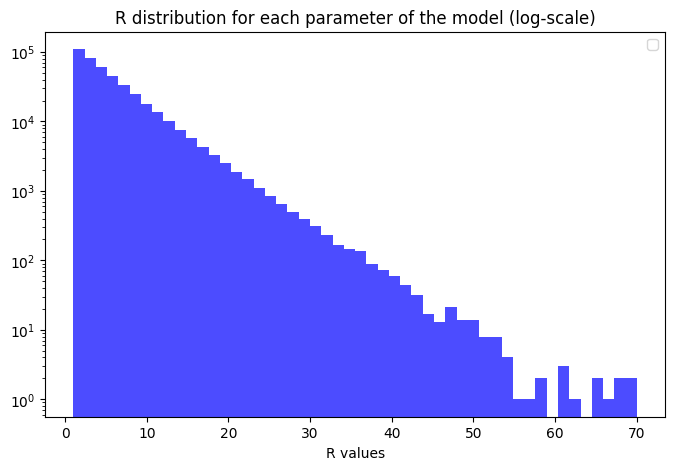

In [16]:
import matplotlib.pyplot as plt

def plot_r_hat_histogram(r_hat_values, title):
    """
    Affiche un histogramme des valeurs de R-hat.

    Paramètres :
        r_hat_values (torch.Tensor) : Valeurs de R-hat pour chaque paramètre.
        title (str): Titre du graphique.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(r_hat_values.cpu().numpy(), bins=50, log=True, color='b', alpha=0.7)
    #plt.axvline(1.2, color='r', linestyle='dashed', linewidth=2, label="1.2 treshold")
    plt.xlabel("R values")
    #plt.ylabel("Nombre de paramètres")
    plt.title(title)
    plt.legend()
    plt.show()

# Afficher l'histogramme des valeurs de R-hat
plot_r_hat_histogram(r_hat_values, "R distribution for each parameter of the model (log-scale)")



### Statistiques sur l'ensemble des fonctions (prédicitons)


Shape de chains_tensor : torch.Size([3, 140, 1000, 10])
R-hat pour chaque image :  1000


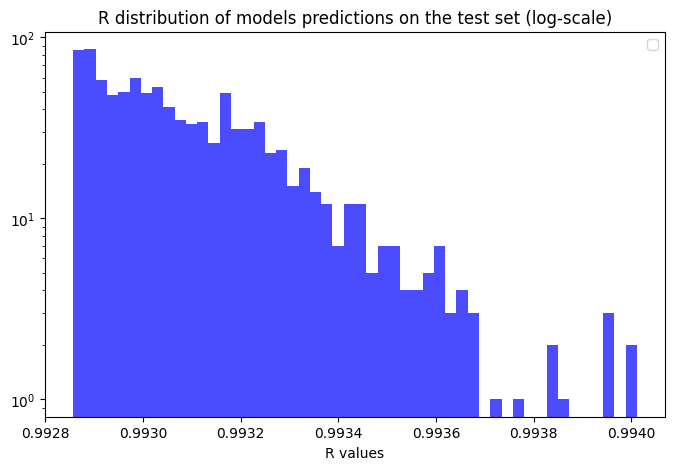

In [18]:
import torch
import torch.nn.functional as F

def compute_r_hat_per_image(chains):
    """
    Calcule la statistique R-hat de Gelman & Rubin pour chaque image du test set dans l'espace des prédictions.

    Paramètres :
        chains (torch.Tensor) : tenseur de forme (M, N, num_samples, num_classes)
                                contenant les prédictions softmax pour chaque chaîne (M), chaque échantillon (N),
                                chaque image du test set (num_samples) et chaque classe (num_classes).

    Retourne :
        torch.Tensor : valeurs de R-hat pour chaque image du test set.
    """
    M, N, num_samples, num_classes = chains.shape  # (M=3, N=num_samples, num_images, num_classes)

    # Moyenne intra-chaîne des prédictions pour chaque image et pour chaque classe
    psi_moyenne = chains.mean(dim=1)  # (M, num_samples, num_classes)

    # Moyenne globale des prédictions pour chaque image et pour chaque classe
    psi_global = psi_moyenne.mean(dim=0)  # (num_samples, num_classes)

    # Variance inter-chaîne B pour chaque image et pour chaque classe
    B = (N / (M - 1)) * ((psi_moyenne - psi_global) ** 2).sum(dim=0)  # (num_samples, num_classes)

    # Variance intra-chaîne W pour chaque image et pour chaque classe
    W = (1 / (M * (N - 1))) * ((chains - psi_moyenne[:, None, :, :]) ** 2).sum(dim=(0, 1, 2))  # (num_samples, num_classes)

    # Estimation ajustée de la variance totale pour chaque image et chaque classe
    sigma_plus = ((N - 1) / N) * W + (B / N)  # (num_samples, num_classes)

    # Calcul de R-hat pour chaque image
    R_hat = ((M + 1) / M) * (sigma_plus / W) - (N - 1) / (M * N)  # (num_samples, num_classes)

    # R-hat moyen sur toutes les classes pour chaque image
    R_hat_per_image = R_hat.mean(dim=-1)  # (num_samples)

    return R_hat_per_image

# Génération des prédictions softmax pour chaque chaîne
chains = []
for params_hmc in [params_hmc_1, params_hmc_2, params_hmc_3]:  
    pred_list, _ = hamiltorch.predict_model(
        net, x=x_val, y=y_val, samples=params_hmc,
        model_loss='multi_class_log_softmax_output',
        tau_out=1.0, tau_list=tau_list
    )

    # Convertir les prédictions en probabilités softmax
    softmax_preds = F.softmax(pred_list, dim=-1)  # (N, num_samples, num_classes)

    # Ajouter une dimension pour M (chaînes)
    chains.append(softmax_preds.unsqueeze(0))  

# Empiler les chaînes pour obtenir la forme correcte (M, N, num_samples, num_classes)
chains_tensor = torch.cat(chains, dim=0)  # (M=3, N=num_samples, num_samples, num_classes)

# Vérification de la forme
print("Shape de chains_tensor :", chains_tensor.shape)  # Devrait être (3, N, num_samples, num_classes)

# Calcul des valeurs de R-hat sur l'espace des fonctions pour chaque image
r_hat_values_function = compute_r_hat_per_image(chains_tensor)

# Affichage des résultats
print("R-hat pour chaque image : ", len(r_hat_values_function))


plot_r_hat_histogram(r_hat_values_function, "R distribution of models predictions on the test set (log-scale)")

In [15]:
len(r_hat_values_function)

1000

### 3 chaînes similaires

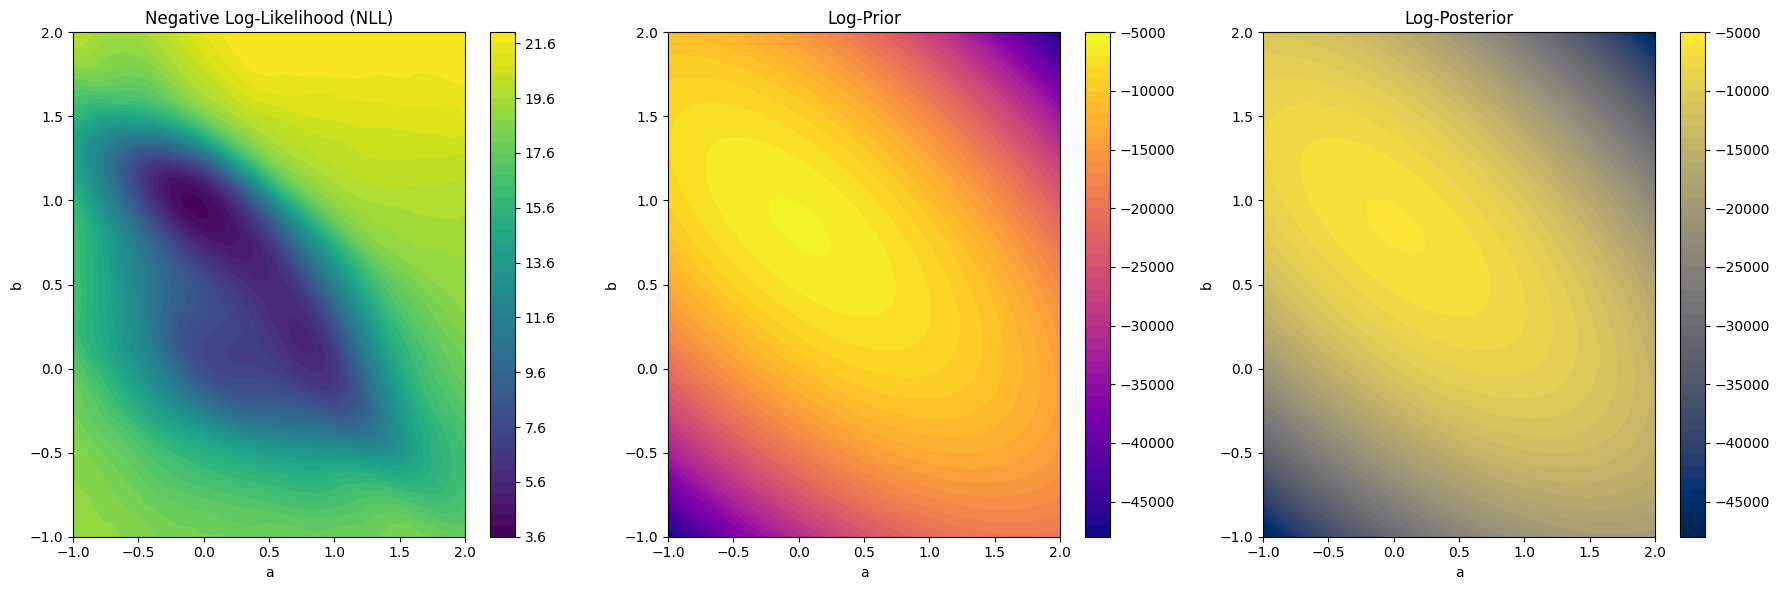

In [21]:
import torch
import hamiltorch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## DIFFERENTES CHAINES
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sélectionner 3 échantillons (1er, 50e, 100e)
w1 = params_hmc_1[40]
w2 = params_hmc_1[90]
w3 = params_hmc_1[139]

# Définir les coefficients a et b
grid_size = 50
a_range = torch.linspace(-1, 2, grid_size)
b_range = torch.linspace(-1, 2, grid_size)

# Construire la grille de paramètres
theta_grid = torch.zeros(grid_size, grid_size, w1.shape[0], device=device)

for i, a in enumerate(a_range):
    for j, b in enumerate(b_range):
        theta_grid[i, j] = a * w1 + b * w2 + (1 - a - b) * w3

# Aplatir la grille pour utiliser predict_model
theta_grid_flat = theta_grid.view(-1, w1.shape[0])

# Prédictions avec hamiltorch
pred_list, _ = hamiltorch.predict_model(
    net, x=x_val, y=y_val, samples=theta_grid_flat, 
    model_loss='multi_class_log_softmax_output', tau_out=1., tau_list=tau_list
)

# Initialisation des grilles
nll_grid = torch.zeros(grid_size, grid_size, device=device)
log_prior_grid = torch.zeros(grid_size, grid_size, device=device)
log_posterior_grid = torch.zeros(grid_size, grid_size, device=device)

# Paramètre du prior (si connu)
tau_prior = 1.0  # À ajuster si besoin
max_nll = 100  # Pour éviter les valeurs extrêmes

for i in range(grid_size * grid_size):
    # Log-likelihood (NLL)
    ensemble_proba = F.softmax(pred_list[i], dim=-1)
    eps = 1e-10  # Éviter log(0)
    ensemble_proba = torch.clamp(ensemble_proba, min=eps)
    nll = F.nll_loss(torch.log(ensemble_proba.cpu()), y_val.cpu().long().flatten(), reduction='mean')

    if torch.isnan(nll) or nll > max_nll:
        nll_grid[i // grid_size, i % grid_size] = max_nll
    else:
        nll_grid[i // grid_size, i % grid_size] = nll

    # Log-prior : Normalement une Gaussienne centrée
    log_prior = - (tau_prior / 2) * torch.norm(theta_grid_flat[i])**2
    log_prior_grid[i // grid_size, i % grid_size] = log_prior

    # Log-posterior = Log-likelihood + Log-prior
    log_posterior_grid[i // grid_size, i % grid_size] = -nll + log_prior

# Conversion en numpy
nll_grid_np = nll_grid.cpu().detach().numpy()
log_prior_np = log_prior_grid.cpu().detach().numpy()
log_posterior_np = log_posterior_grid.cpu().detach().numpy()

# Affichage des trois heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# NLL
im1 = axes[0].contourf(a_range.cpu().numpy(), b_range.cpu().numpy(), nll_grid_np, levels=50, cmap="viridis")
fig.colorbar(im1, ax=axes[0])
axes[0].set_title("Negative Log-Likelihood (NLL)")
axes[0].set_xlabel("a")
axes[0].set_ylabel("b")

# Log-prior
im2 = axes[1].contourf(a_range.cpu().numpy(), b_range.cpu().numpy(), log_prior_np, levels=50, cmap="plasma")
fig.colorbar(im2, ax=axes[1])
axes[1].set_title("Log-Prior")
axes[1].set_xlabel("a")
axes[1].set_ylabel("b")

# Log-posterior
im3 = axes[2].contourf(a_range.cpu().numpy(), b_range.cpu().numpy(), log_posterior_np, levels=50, cmap="cividis")
fig.colorbar(im3, ax=axes[2])
axes[2].set_title("Log-Posterior")
axes[2].set_xlabel("a")
axes[2].set_ylabel("b")

plt.tight_layout()
plt.show()
